In [ ]:
!curl -LJO https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/MulticlassDiabetesDataset.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11022  100 11022    0     0  72439      0 --:--:-- --:--:-- --:--:-- 72513


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.model_selection import train_test_split


In [ ]:
data = pd.read_csv('MulticlassDiabetesDataset.csv')

num_clase_0 = data['Class'].value_counts()[0]
num_clase_1 = data['Class'].value_counts()[1]
num_clase_2 = data['Class'].value_counts()[2]

print("Clase 0: " + str(num_clase_0))
print("\nClase 1: " + str(num_clase_1))
print("\nClase 2: " + str(num_clase_2))

Clase 0: 96

Clase 1: 40

Clase 2: 128


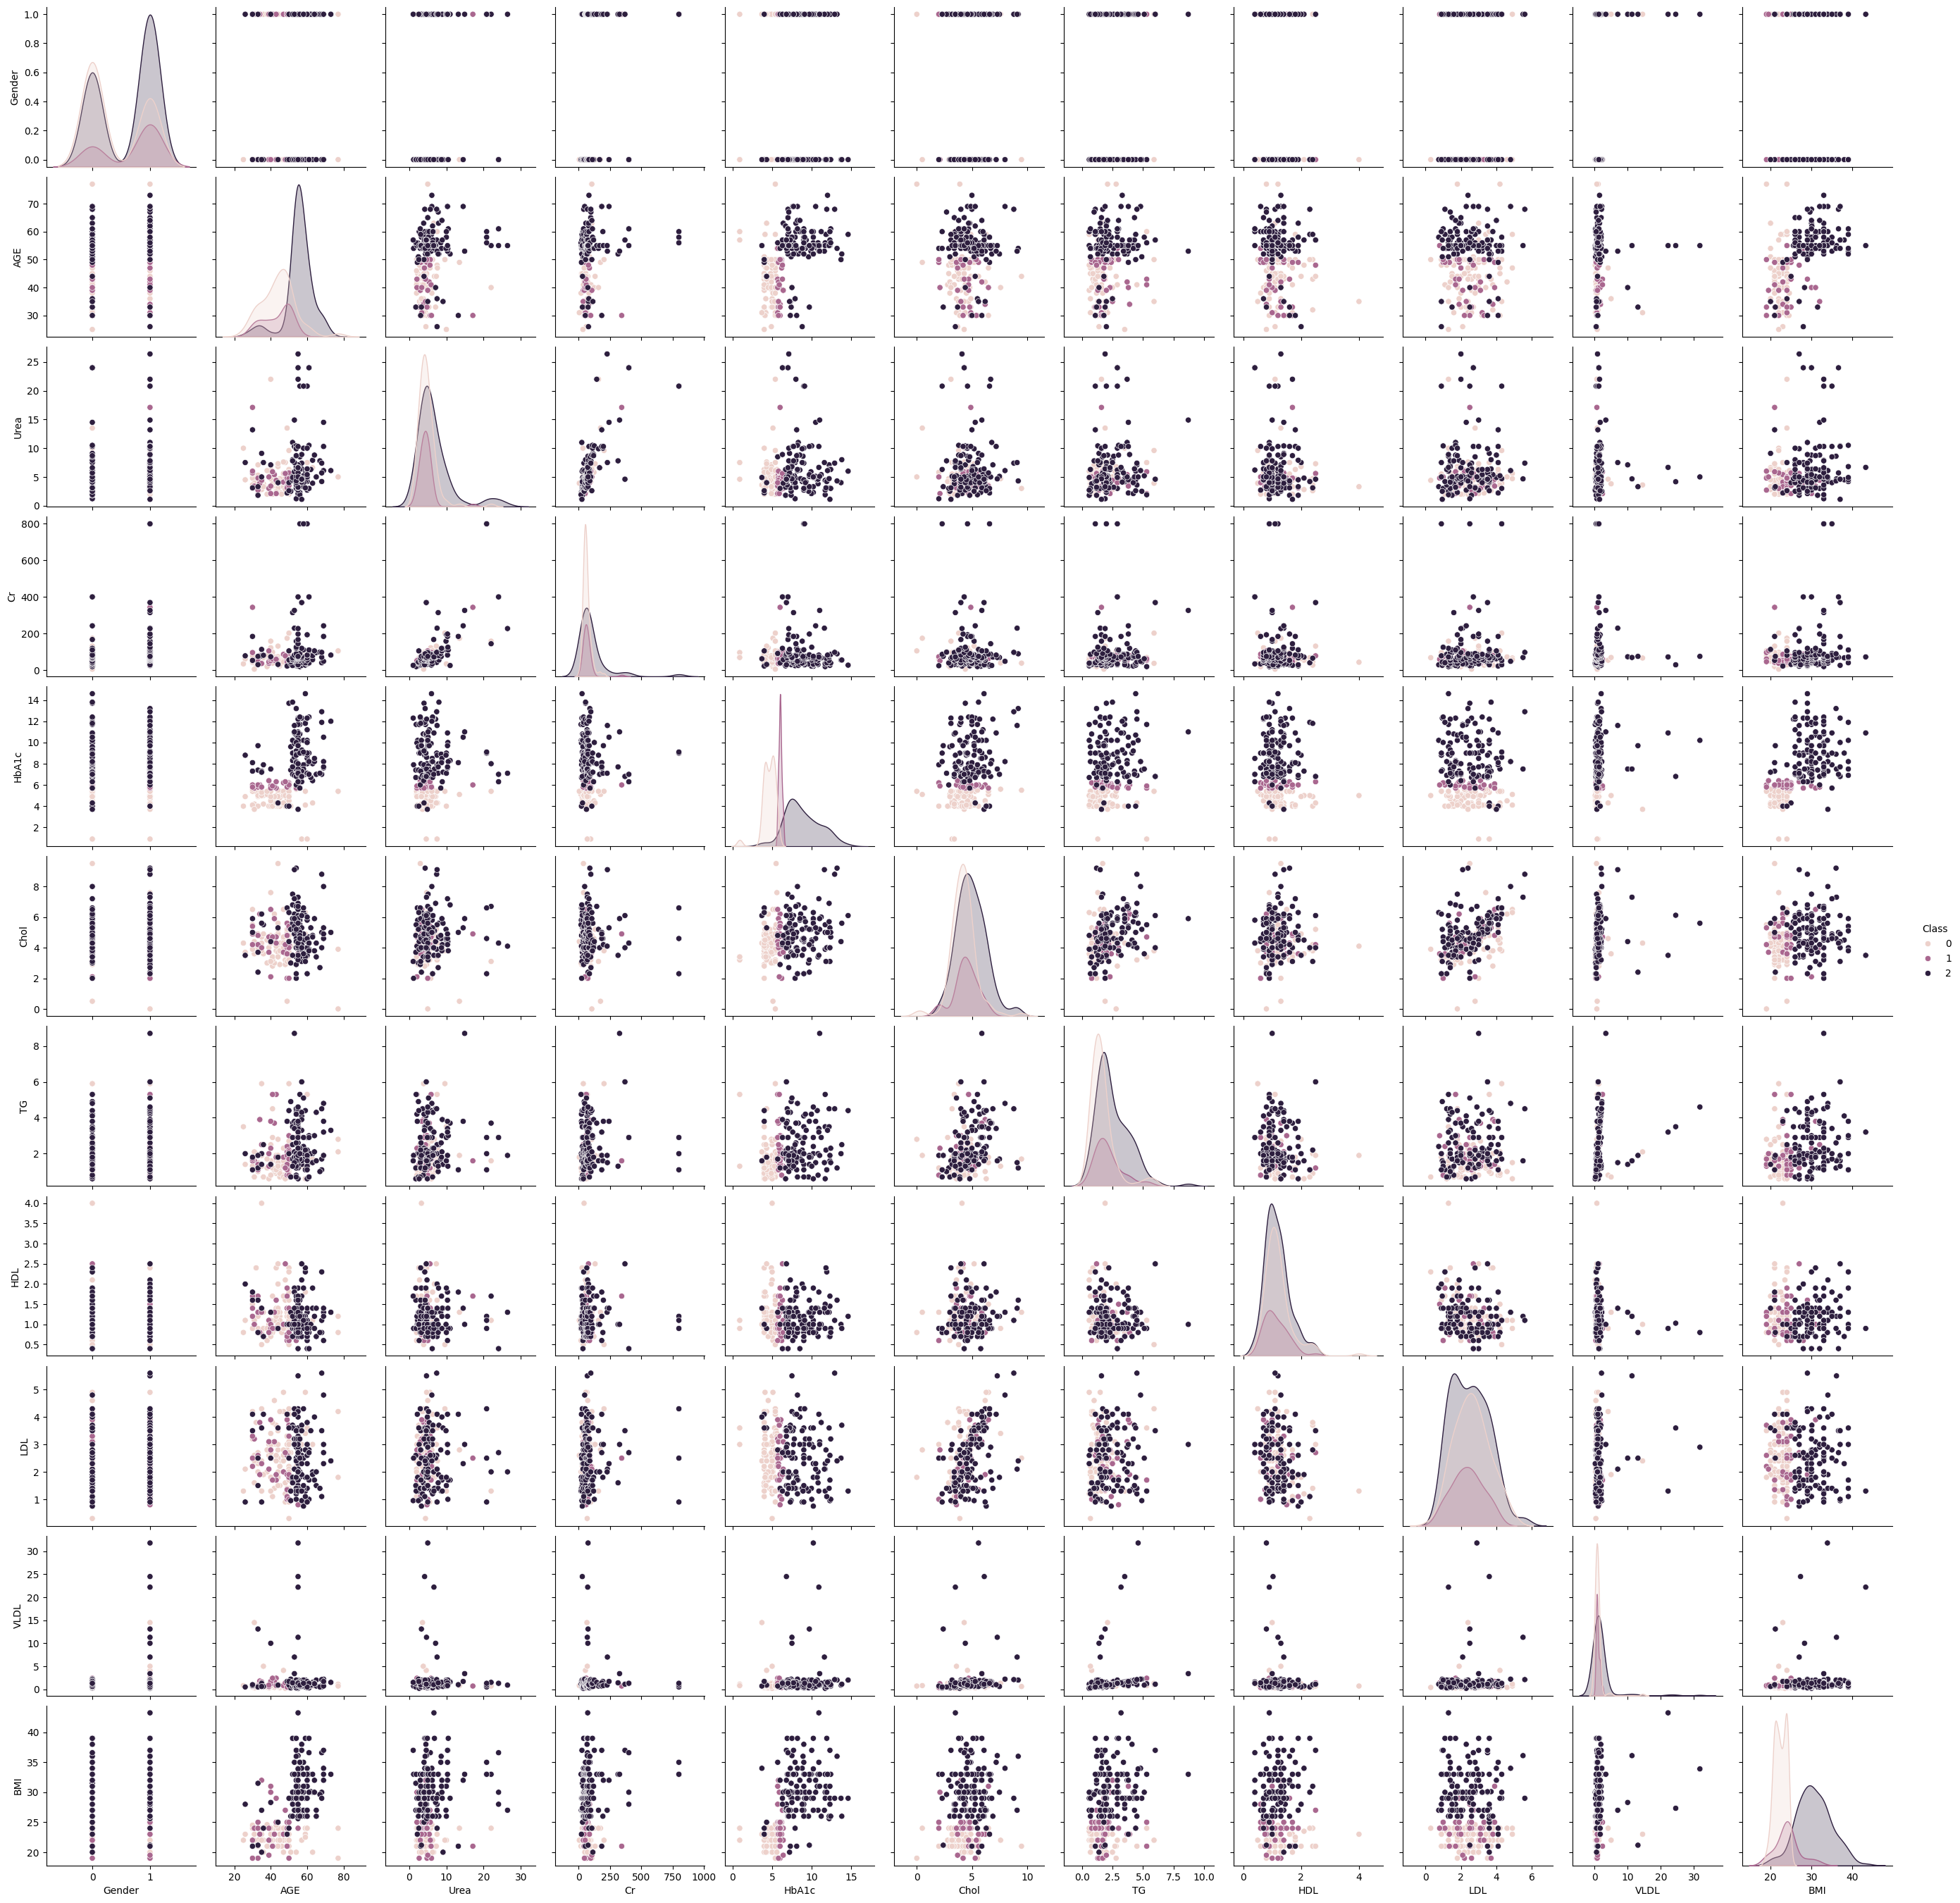

In [ ]:
sea.pairplot(data, hue = 'Class') #El grafico muestra cada par de features en un plano y un histograma sobre cada feature en la diagonal. HbA1c parece ser la mejor variable para la predicción ya que su valor me da una forma determinante de decidir la clase objetivo

In [ ]:
#Separo las salidas y divido en testeo y training

X = data.drop(['Class'], axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [ ]:
class LDA_QDA:
  def __init__(self, LDA=False):
    self.clases = None
    self.muks = []
    self.Sks = []
    self.cks = []
    self.S = None
    self.LDA = LDA
    return

  def fit(self, X, y):
    #Convierto a np por facilidad
    X = X.to_numpy()
    y = y.to_numpy()

    #Tomo las clases
    self.clases = np.unique(y)
    for k in self.clases:
      Dk = X[y == k]
      numDk = len(Dk)

      ck = numDk/len(X)

      muk = np.mean(Dk, axis=0)

      #Creo mi vector de medias
      self.muks.append(muk)
      self.cks.append(ck)

      #Calculo y junto las varianzas, veo el caso de una sola dimension
      Sk = (Dk - muk).T@(Dk - muk)/(numDk - 1)
      if Sk.shape == (1, 1):
        Sk = Sk.item()
      self.Sks.append(Sk)

      #Acumulo para el calculo de la matriz de covarianza global
      if self.S  is None:
        self.S = (numDk-1)/(len(X) - len(self.clases))*Sk
      else:
        self.S += (numDk-1)/(len(X) - len(self.clases))*Sk

    self.muks = np.array(self.muks)
    self.cks = np.array(self.cks)

    return



  def predict(self, X):
    #Obtengo el argmax
    return np.argmax(self.predict_discriminant(X), axis=1)

  def predict_proba(self, X):
    #Obtengo el discriminante
    disc = self.predict_discriminant(X)

    #Calculo la proba con la softmax
    num = np.exp(self.predict_discriminant(X))
    den = np.sum(num, axis=1, keepdims=True)
    return num/den

  def predict_discriminant(self, X):
    #Si se pasa un df lo paso a np
    if isinstance(X, pd.DataFrame):
      X = X.to_numpy()

    #Separo entre LDA y QDA
    if self.LDA:
      #Separo por dimensiones
      if np.ndim(self.S) > 0:
        invS = np.linalg.inv(self.S)
        return X@invS@self.muks.T + np.log(self.cks) - np.sum(0.5*self.muks@invS*self.muks, axis=1)
      else:
        invS = 1/self.S
        return X*invS*self.muks.T + np.log(self.cks) - np.sum(0.5*(self.muks*invS)*self.muks, axis=1)
    else:
      #Itero para cada clase porque ahora tienen varianzas distintas
      disc = np.zeros((len(X), len(self.clases)))
      for k, (mu, Sk, ck) in enumerate(zip(self.muks, self.Sks, self.cks)):
        if np.ndim(Sk) > 0:
          invSk = np.linalg.inv(Sk)
          discriminant = np.log(ck) - 0.5*np.sum((X-mu)@invSk*(X - mu),axis=1) - 0.5*np.log(np.linalg.det(Sk))
        else:
          invSk = 1/Sk
          discriminant = np.log(ck) - 0.5*np.sum((X-mu)*invSk*(X - mu), axis=1) - 0.5*np.log(Sk)

        disc[:, k] = discriminant
      return disc


In [ ]:
#Me separo los HbA1c
X_test_H = X_test[['HbA1c']]
X_train_H = X_train[['HbA1c']]

#Creo un array uniforme para hacer graficos
X_graf = np.linspace(X_test_H.min(), X_test_H.max(), 100)


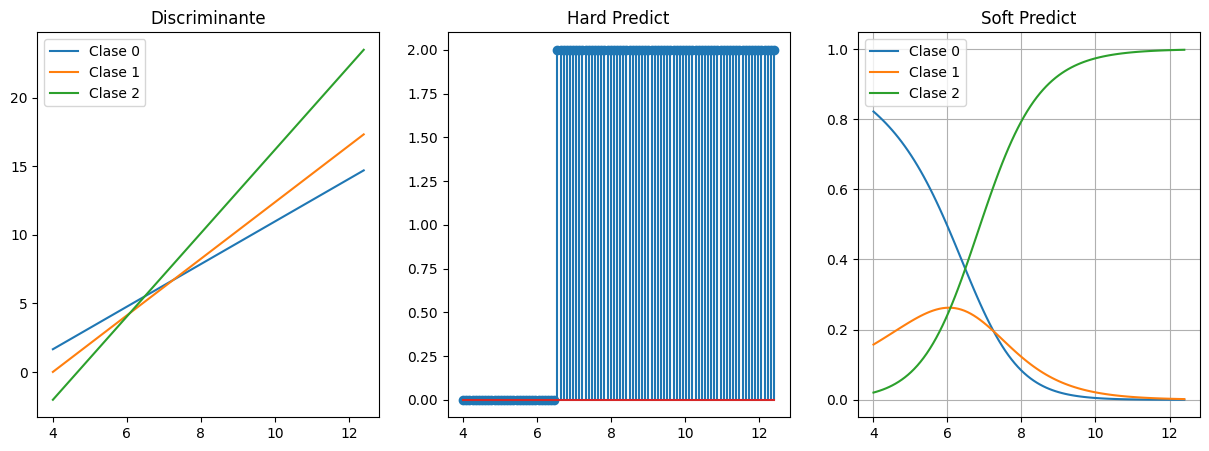

In [ ]:
#Entreno y predigo el discriminante para graficar
lda = LDA_QDA(LDA = True)

lda.fit(X_train_H, y_train)

d_lda = lda.predict_discriminant(X_graf)

#Hago el hard predict
y_pred_lda = lda.predict(X_graf)

#Hago el softpredict
probs_lda = lda.predict_proba(X_graf)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(X_graf, d_lda[:, 0])
axs[0].plot(X_graf, d_lda[:, 1])
axs[0].plot(X_graf, d_lda[:, 2])

axs[0].legend(["Clase 0", "Clase 1", "Clase 2"])
axs[0].title.set_text("Discriminante")

axs[1].stem(X_graf, y_pred_lda)
axs[1].title.set_text("Hard Predict")

axs[2].plot(X_graf, probs_lda[:, 0])
axs[2].plot(X_graf, probs_lda[:, 1])
axs[2].plot(X_graf, probs_lda[:, 2])

axs[2].legend(["Clase 0", "Clase 1", "Clase 2"])
axs[2].title.set_text("Soft Predict")

plt.grid()
plt.show()


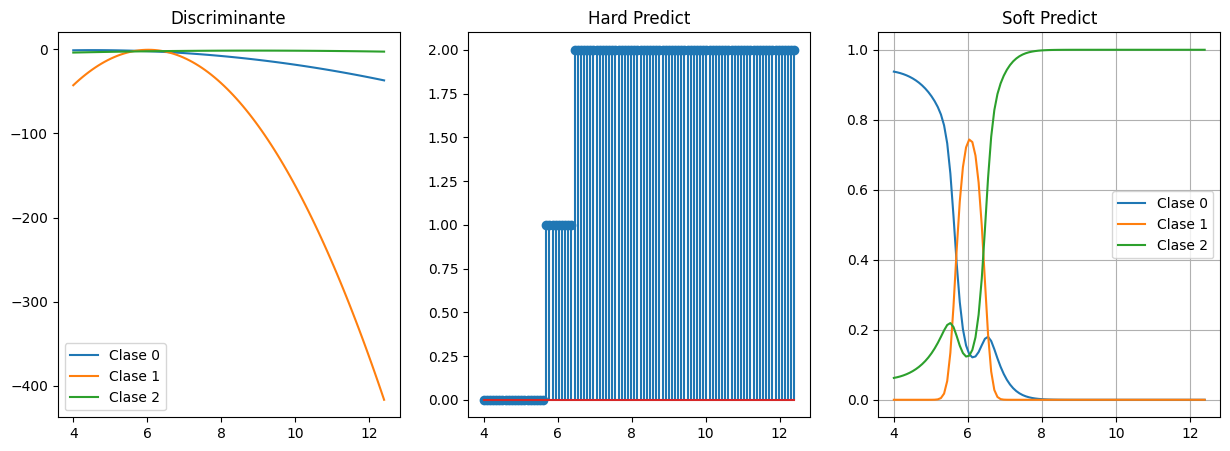

In [ ]:
#Lo mismo pero con qda
qda = LDA_QDA(LDA = False)

qda.fit(X_train_H, y_train)

d_qda = qda.predict_discriminant(X_graf)
y_pred_qda = qda.predict(X_graf)
probs_qda = qda.predict_proba(X_graf)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(X_graf, d_qda[:, 0])
axs[0].plot(X_graf, d_qda[:, 1])
axs[0].plot(X_graf, d_qda[:, 2])

axs[0].legend(["Clase 0", "Clase 1", "Clase 2"])
axs[0].title.set_text("Discriminante")

axs[1].stem(X_graf, y_pred_qda)
axs[1].title.set_text("Hard Predict")

axs[2].plot(X_graf, probs_qda[:, 0])
axs[2].plot(X_graf, probs_qda[:, 1])
axs[2].plot(X_graf, probs_qda[:, 2])

axs[2].legend(["Clase 0", "Clase 1", "Clase 2"])
axs[2].title.set_text("Soft Predict")

plt.grid()
plt.show()



In [ ]:
#Metricas para LDA

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

y_pred_lda = lda.predict(X_test_H)

acc = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_lda)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_lda, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.7547
Matriz de confusión:
[[20  0  0]
 [12  0  0]
 [ 1  0 20]]
Macro F1: 0.5768


In [ ]:
#Metricas para QDA

y_pred_qda = qda.predict(X_test_H)

acc = accuracy_score(y_test, y_pred_qda)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_qda)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_qda, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.9811
Matriz de confusión:
[[20  0  0]
 [ 0 12  0]
 [ 0  1 20]]
Macro F1: 0.9785


In [ ]:
#Creo mis datos con BMI

X_test_HB = X_test[['BMI','HbA1c']]
X_train_HB = X_train[['BMI','HbA1c']]

#Creo una mesh para graficar
BMI_mesh = np.linspace(X_train_HB['BMI'].min(), X_train_HB['BMI'].max(), 50)
HbA1c_mesh = np.linspace(X_train_HB['HbA1c'].min(), X_train_HB['HbA1c'].max(), 50)

BMI_mesh, HbA1c_mesh = np.meshgrid(BMI_mesh, HbA1c_mesh)

#Para pasarle al modelo
X_grid = np.c_[BMI_mesh.ravel(), HbA1c_mesh.ravel()]


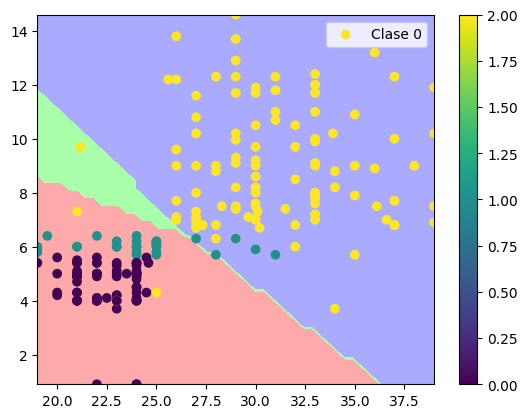

In [ ]:
import matplotlib.colors as mcolors

lda = LDA_QDA(LDA = True)

lda.fit(X_train_HB, y_train)

y_pred_lda = lda.predict(X_grid)

cmap = mcolors.ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
plt.contourf(BMI_mesh, HbA1c_mesh, y_pred_lda.reshape(BMI_mesh.shape), levels=20, cmap=cmap)

plt.scatter(X_train_HB['BMI'], X_train_HB['HbA1c'], c=y_train)
plt.legend(["Clase 0", "Clase 1", "Clase 2"])
plt.colorbar()
plt.show()


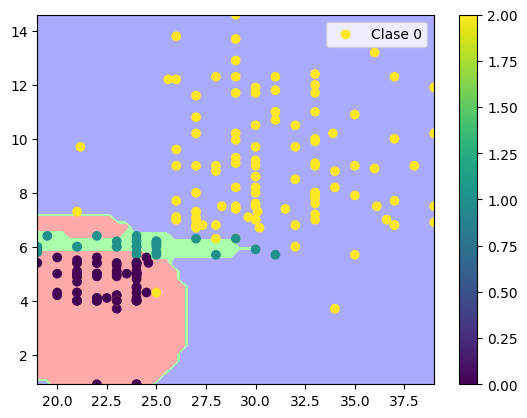

In [ ]:
qda = LDA_QDA(LDA = False)

qda.fit(X_train_HB, y_train)

y_pred_qda = qda.predict(X_grid)

cmap = mcolors.ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
plt.contourf(BMI_mesh, HbA1c_mesh, y_pred_qda.reshape(BMI_mesh.shape), levels=20, cmap=cmap)
plt.scatter(X_train_HB['BMI'], X_train_HB['HbA1c'], c=y_train)
plt.legend(["Clase 0", "Clase 1", "Clase 2"])
plt.colorbar()
plt.show()

In [ ]:
#Metricas LDA
y_pred_lda = lda.predict(X_test_HB)

acc = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_lda)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_lda, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

#Es logico que den diferentes ya que el F1 es la metrica utilizada para cuando las clases estan desbalanceadas que se adapta mejor a nuestro caso en comparación con el

Accuracy: 0.7170
Matriz de confusión:
[[20  0  0]
 [11  0  1]
 [ 1  2 18]]
Macro F1: 0.5564


In [ ]:
#Metricas QDA
y_pred_qda = qda.predict(X_test_HB)

acc = accuracy_score(y_test, y_pred_qda)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_qda)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_qda, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.9623
Matriz de confusión:
[[20  0  0]
 [ 0 11  1]
 [ 1  0 20]]
Macro F1: 0.9615


In [ ]:
lda = LDA_QDA(LDA = True)

lda.fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)

acc = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_lda)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_lda, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.8302
Matriz de confusión:
[[20  0  0]
 [ 5  6  1]
 [ 3  0 18]]
Macro F1: 0.8000


In [ ]:
qda = LDA_QDA(LDA = False)

qda.fit(X_train, y_train)

y_pred_qda = qda.predict(X_test)

acc = accuracy_score(y_test, y_pred_qda)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_qda)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_qda, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.8302
Matriz de confusión:
[[18  1  1]
 [ 3  7  2]
 [ 1  1 19]]
Macro F1: 0.8025


In [ ]:
class KNN:
  def __init__(self, k):
    self.k = k
    self.X = None
    self.y = None

  def fit(self, X, y):
    self.X = X.to_numpy()
    self.y = y.to_numpy()
    return

  def predict(self, X):
    probas = self.predict_proba(X)
    return np.argmax(probas, axis=1)


  def predict_proba(self, X):
    if isinstance(X, pd.DataFrame):
      X = X.to_numpy()
    probas = []
    for x in X:
      #Calculo distancias y guardo los k mas cercanos
      distances = np.linalg.norm(self.X - x, axis=1)
      k_indices = np.argsort(distances)[:self.k]
      k_labels = self.y[k_indices]

      #Hago la proporcion de cada clase para saber las probas
      count_0 = np.sum(k_labels == 0)
      count_1 = np.sum(k_labels == 1)
      count_2 = np.sum(k_labels == 2)
      probs = [count_0/self.k, count_1/self.k, count_2/self.k]
      probas.append(probs)

    return np.array(probas)




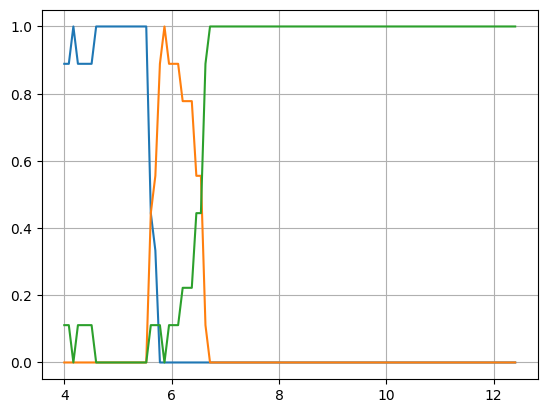

In [ ]:
knn = KNN(9)

knn.fit(X_train_H, y_train)

proba = knn.predict_proba(X_graf)

plt.plot(X_graf, proba[:, 0])
plt.plot(X_graf, proba[:, 1])
plt.plot(X_graf, proba[:, 2])

plt.grid()
plt.show()


In [ ]:
#Predigo con knn

y_pred_knn = knn.predict(X_test_H)


In [ ]:
#Metricas

acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_knn)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_knn, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.9811
Matriz de confusión:
[[20  0  0]
 [ 0 12  0]
 [ 0  1 20]]
Macro F1: 0.9785


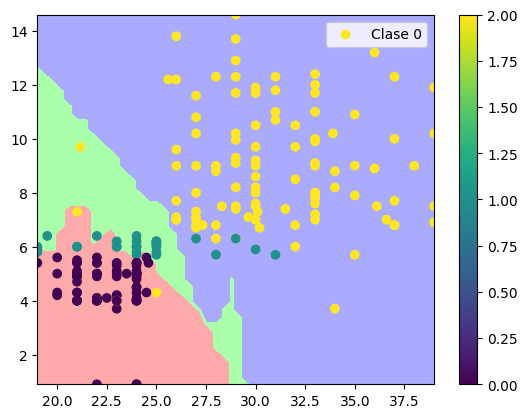

In [ ]:
knn = KNN(9)

knn.fit(X_train_HB, y_train)

y_pred_knn = knn.predict(X_grid)

cmap = mcolors.ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
plt.contourf(BMI_mesh, HbA1c_mesh, y_pred_knn.reshape(BMI_mesh.shape), levels=20, cmap=cmap)
plt.scatter(X_train_HB['BMI'], X_train_HB['HbA1c'], c=y_train)
plt.legend(["Clase 0", "Clase 1", "Clase 2"])
plt.colorbar()
plt.show()

In [ ]:
#Predigo con knn

y_pred_knn = knn.predict(X_test_HB)

In [ ]:
# Metricas
acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_knn)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_knn, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.8679
Matriz de confusión:
[[20  0  0]
 [ 3  8  1]
 [ 0  3 18]]
Macro F1: 0.8420


In [ ]:
knn = KNN(9)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

In [ ]:
#Metricas
acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_knn)
print("Matriz de confusión:")
print(cm)

macro_f1 = f1_score(y_test, y_pred_knn, average='macro')
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.6604
Matriz de confusión:
[[16  2  2]
 [11  1  0]
 [ 3  0 18]]
Macro F1: 0.5505
